# Inventory EDA

Inventory Data contains snapshot information about sku-level tons that were available in inventory at a specific date. This data pertains to Whitby mill (1302). 

One important consideration - the numbers in inventory could decrease by:
 1. Shipments
 2. Scrapping

Our assumption for this analysis is that most of the decreases will be derived from shipments. Thus the rate of change we assume to be equal to the rate of shipments for the items in analysis. 

**Given limited time for analysis we will focus on specific blocks**
- 4" ANG
- 5X3-1/2" ANG
- 5X3" ANG
- 4X3" ANG
- 3-1/2" ANG

Exploration areas:
- Distribution of inventory through time
- Is there cyclicality to inventory from month to month, or cycle to cycle
- Analysis on the cycle lenghts (avg. and std deviations)
- **Potential features that could serve as indicators for the prediction of production quantities**
    - rate of change in inventory increasing decreasing (especially in comparison to ATP available)
    - ...

#### Dependencies

In [3]:
#dependencies for EDA
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ipywidgets as widgets
import plotly as py
import plotly.graph_objs as go

#### Read Dataframe

In [4]:
%store -r inv_reduced

## Peaking at Data

In [5]:
#peak
inv_reduced.head()

,calendar_day,strategy,sku,material_description,work_center,ph,shape,size,block,tons,atp
799352,2017-01-01,63,102003236,"BL 5 1/8X7 3/8 1010M-446_1302 3,800",18000001.0,LS-Mills-Bil-Bil-Bil-Billets,RECTANGULAR,5 1/8 X 7 3/8,NaN,9.442000,0.0
799094,2017-01-01,63,102003053,"BL 5 1/8X7 3/8 1010M-446_1302 3,858 SA",18000001.0,LS-Mills-Bil-Bil-Bil-Billets,RECTANGULAR,5 1/8 X 7 3/8,NaN,1.929000,0.0
799267,2017-01-01,63,102003353,BL 5 1/8X7 3/8 GAU_1050-501_1302 3168 SA,18000001.0,LS-Mills-Bil-Bil-Bil-Billets,RECTANGULAR,5 1/8 X 7 3/8,NaN,7.920000,0.0
799180,2017-01-01,63,102003354,BL 5 1/8X7 3/8 GAU_MG12-500_1302 3220 SA,18000001.0,LS-Mills-Bil-Bil-Bil-Billets,RECTANGULAR,5 1/8 X 7 3/8,NaN,11.380000,0.0
844399,2017-01-01,40,106020238,"C 10X15.3# GGMULTI 20'00""",25000001.0,LS-Mills-Mer-Mer-Strc A&C-Channels,SHAPE_C,10 X 15.3#,"10"" CHN",110.007004,0.0


In [6]:
#counts and dtypes
inv_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649986 entries, 799352 to 18367
Data columns (total 11 columns):
calendar_day            649986 non-null datetime64[ns]
strategy                649986 non-null category
sku                     649986 non-null object
material_description    649986 non-null object
work_center             649979 non-null category
ph                      649986 non-null object
shape                   647514 non-null object
size                    647514 non-null object
block                   626217 non-null object
tons                    649986 non-null float64
atp                     649986 non-null float64
dtypes: category(2), datetime64[ns](1), float64(2), object(6)
memory usage: 50.8+ MB


In [7]:
#creating dataframe for analysis of null blocks in inventory
null_blocks = inv_reduced[inv_reduced["block"].isna()]

In [8]:
#looking to see offenders in Angle shapes (L_SHAPE)
null_blocks[null_blocks["shape"]=="SHAPE_L"]["size"].value_counts()

2 1/2X2X1/4         1660
1 1/4X1 1/4X3/16    1032
1 1/4X1 1/4X1/8      825
2 1/2X2X3/16         812
2 1/2X2X5/16         494
3 1/2X3X3/8          489
4X3 1/2X1/4          136
1X1X1/8               57
2X1 1/2X3/16          24
1 1/4X1 1/4X1/4       23
1X1X1/4               23
1X1X3/16              22
3/4X3/4X1/8           15
1 3/4X1 3/4X1/8        3
2X1 1/2X1/4            2
8X6X1                  1
8X6X3/4                1
1 1/2X1 1/2X1/8        1
Name: size, dtype: int64

No offenders apparent in 4" ANG block:
- 4 X 4 X .344 UNB
- 4 X 4 X 1/2
- 4 X 4 X 1/4
- 4 X 4 X 3/4
- 4 X 4 X 3/8
- 4 X 4 X 5/16
- 4 X 4 X 7/16
- 4 X 4 X 9/16
- 4 X 4 X 5/8

## Distribution of Inventory through Time

### 4" ANG Analysis (to be used for replication)

In [9]:
#dataframe for (variable) block analysis
block_df = inv_reduced[inv_reduced["block"]=='4" ANG']

In [10]:
#number of skus in this block
block_df["sku"].nunique()

104

In [11]:
#description of block
block_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30681 entries, 823677 to 1953
Data columns (total 11 columns):
calendar_day            30681 non-null datetime64[ns]
strategy                30681 non-null category
sku                     30681 non-null object
material_description    30681 non-null object
work_center             30681 non-null category
ph                      30681 non-null object
shape                   30681 non-null object
size                    30681 non-null object
block                   30681 non-null object
tons                    30681 non-null float64
atp                     30681 non-null float64
dtypes: category(2), datetime64[ns](1), float64(2), object(6)
memory usage: 2.4+ MB


In [12]:
#quick description of 4" ANG inventory tons and ATP
block_df.describe()

,tons,atp
count,30681.000000,30681.000000
mean,52.094909,4.494928
std,128.352124,27.550241
min,-0.002000,-298.690000
25%,0.001000,0.000000
50%,3.145000,0.000000
75%,42.966000,0.000000
max,1859.219971,617.876000


In [13]:
#Creating new columns to separate year, month and week
block_df = block_df.set_index("calendar_day")
block_df["year"] = block_df.index.year
block_df["month"] = block_df.index.month
block_df["week"] = block_df.index.week
block_df["day"] = block_df.index.dayofyear
block_df = block_df.reset_index()

In [14]:
block_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30681 entries, 0 to 30680
Data columns (total 15 columns):
calendar_day            30681 non-null datetime64[ns]
strategy                30681 non-null category
sku                     30681 non-null object
material_description    30681 non-null object
work_center             30681 non-null category
ph                      30681 non-null object
shape                   30681 non-null object
size                    30681 non-null object
block                   30681 non-null object
tons                    30681 non-null float64
atp                     30681 non-null float64
year                    30681 non-null int64
month                   30681 non-null int64
week                    30681 non-null int64
day                     30681 non-null int64
dtypes: category(2), datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 3.1+ MB


In [15]:
#Rearranging columns order
cols = list(block_df.columns.values)
cols = ['calendar_day', 'year', 'month', 'week', "day",'strategy', 'sku', 'material_description', 
        'work_center', 'ph', 'shape', 'size', 'block', 'tons', 'atp']
block_df =block_df[cols]

In [86]:
block_df[block_df["year"]==2019]["day"].value_counts()

219    50
209    50
224    50
216    50
220    50
       ..
197    33
99     32
97     32
98     32
195    13
Name: day, Length: 272, dtype: int64

In [17]:
#distribution of inventory snapshots through years 
block_df["year"].value_counts()

2019    10745
2018    10280
2017     8180
2020     1476
Name: year, dtype: int64

In [66]:
#distribution of inventory snapshots by size
block_df["size"].value_counts()

4X4X5/16    9077
4X4X3/8     6346
4X4X1/4     4836
4X4X1/2     3280
4X4X3/4     2501
4X4X9/16    2475
4X4X.344    1386
4X4X5/8      688
4X4X7/16      92
Name: size, dtype: int64

Tons on Inventory

Text(0, 0.5, 'Tons')

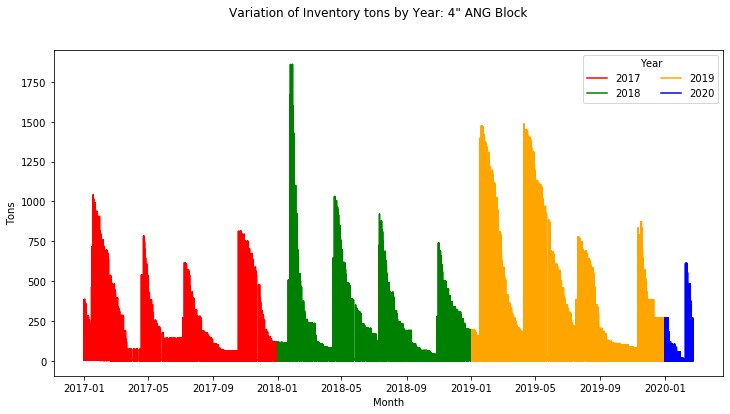

In [63]:
#creating df for each year
year_2017 = block_df[block_df.year == 2017]
year_2018 = block_df[block_df.year == 2018]
year_2019 = block_df[block_df.year == 2019]
year_2020 = block_df[block_df.year == 2020]

#Create figure and plots
fig_dims = (12,6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Variation of Inventory tons by Year: 4" ANG Block')

ax.plot(year_2017.calendar_day, year_2017["tons"], label=2017, color ='r')
ax.plot(year_2018.calendar_day, year_2018["tons"], label=2018, color ='g')
ax.plot(year_2019.calendar_day, year_2019["tons"], label=2019, color ='orange')
ax.plot(year_2020.calendar_day, year_2020["tons"], label=2020, color ='b')

#Create legend & axis names
plt.legend(loc="best", title="Year", ncol=2)
ax.set_xlabel("Time")
ax.set_ylabel("Tons")

ATP for this Block

Text(0, 0.5, 'APT(in tons)')

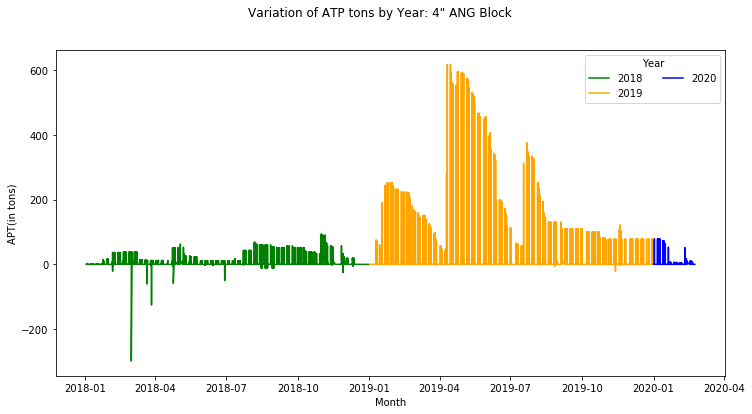

In [23]:
#Create figure and plots
fig_dims = (12,6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Variation of ATP tons by Year: 4" ANG Block')

#ax.plot(year_2017.calendar_day, year_2017["atp"], label=2017, color ='r')
ax.plot(year_2018.calendar_day, year_2018["atp"], label=2018, color ='g')
ax.plot(year_2019.calendar_day, year_2019["atp"], label=2019, color ='orange')
ax.plot(year_2020.calendar_day, year_2020["atp"], label=2020, color='b')

#Create legend & axis names
plt.legend(loc="best", title="Year", ncol=2)
ax.set_xlabel("Time")
ax.set_ylabel("APT(in tons)")

In [49]:
##Checkout ipywidgets? - https://plotly.com/python/widget-app/   &   https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
## If not continue exploring ways to plot simulatenously ATP

### Inventory & ATP Analysis

In [143]:
#Create Dropdown for blocks & sizes
blocks = widgets.Dropdown(options=['4" ANG','5 X 3-1/2" ANG','5 X 3" ANG','4 X 3" ANG', '3-1/2" ANG'])
sizes = widgets.Dropdown(options=list(inv_reduced[inv_reduced.block==blocks.value]["size"].value_counts().index))

#DATEPICKER IS NOT WORKING
#start = widgets.DatePicker(description="Start Date", value=pd.to_datetime('2019-01-01'))
#end = widgets.DatePicker(description="End Date", value=pd.to_datetime('2020-01-01'))

#Update the size options from blocks picked
def update_sizes(*args):
    sizes.options = list(inv_reduced[inv_reduced.block==blocks.value]["size"].value_counts().index)
#observing changes in blocks
blocks.observe(update_sizes, 'value')
    
@widgets.interact
def line_plot(Aggregate_Block=False, Show_ATP=True, Block = blocks, Size= sizes, Start= start, End= end):
    fig_dims = (16,8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plot_df = inv_reduced[(inv_reduced["calendar_day"]>=start.value) & (inv_reduced["calendar_day"]<=end.value)]
    plot_df = inv_reduced[inv_reduced["block"]==blocks.value]
    if Aggregate_Block == False:
        plot_df = plot_df[plot_df["size"] == sizes.value]
        sizes.disabled=False
    else:
        sizes.disabled=True
    fig.suptitle('Variation of Inventory & ATP')
    ax.plot(plot_df["calendar_day"], plot_df["tons"],alpha=.5, label= "Inventory")
    if Show_ATP == True:
        ax.plot(plot_df["calendar_day"], plot_df["atp"], alpha=.3, label= "ATP")
    plt.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Tons")
    

interactive(children=(Checkbox(value=False, description='Aggregate_Block'), Checkbox(value=True, description='…

### Find Patterns

#### Calculate Cycle Lenghts

#### Calculate Rate of Inventory Change

#### Calculate Relations ATP vs. Inventory

#### Ensure Rate of Ship == Rate of Inv. Decrease

#### Create Orders substitute(Inventory-ATP) to explore this as potential attributes